In [1]:
import mujoco
import numpy as np

In [2]:

# Compliant tendon parameter structure
class CompliantTendonParams:
    def __init__(self, F_max, l_opt, l_slack, v_max, W, C, N, K, E_REF):
        self.F_max = F_max
        self.l_opt = l_opt
        self.l_slack = l_slack
        self.v_max = v_max
        self.W = W
        self.C = C
        self.N = N
        self.K = K
        self.E_REF = E_REF
    def get_prm_str(self):
        return f"{self.F_max} {self.l_opt} {self.l_slack} {self.v_max} {self.W} {self.C} {self.N} {self.K} {self.E_REF}"

# Standard muscle parameter structure
# https://mujoco.readthedocs.io/en/stable/modeling.html#cmuscle
class DefaultParams:
    def __init__(self, range_min, range_max, force, scale, lmin, lmax, vmax, fpmax, fvmax):
        # muscle range: unit: l_opt
        self.range_min = range_min
        self.range_max = range_max
        # peak force(N)
        self.force = force
        # ignore
        self.scale = scale
        # active force min length; unit: l_opt
        self.lmin = lmin
        # active force max length; unit: l_opt
        self.lmax = lmax
        # active force max shortening velocity; unit: l_opt/s
        self.vmax = vmax
        # passive force at max length(range_max); unit: 1(ratio to fmax)
        self.fpmax = fpmax
        # Active force generated at saturating lengthening velocity, unit: 1(ratio to fmax)
        self.fvmax = fvmax
    def get_prm_str(self):
        return f"{self.range_min} {self.range_max} {self.force} {self.scale} {self.lmin} {self.lmax} {self.vmax} {self.fpmax} {self.fvmax}"




In [3]:
def create_model(cp_params:CompliantTendonParams, default_params:DefaultParams):
    xml_string = f"""
    <mujoco model="compliant_muscle_test">
    <!-- cmtu_integrator: Euler, RK4, ODE15s -->
    <option timestep="0.001" gravity="0 0 -9.81" integrator="Euler"/>

    <default>
        <!-- Compliant muscle default class -->
        <!-- F_max, l_opt, l_slack, v_max, W, C, N, K, E_REF -->
        <default class="compliant_muscle">
        <general biasprm="0" biastype="none" ctrllimited="true" ctrlrange="0 1" 
                dynprm="0.01 0.04" dyntype="muscle" 
                gainprm="{cp_params.get_prm_str()}" 
                gaintype="compliant_mtu"/>
        </default>
        
        <!-- Standard muscle for comparison -->
        <default class="standard_muscle">

        <!-- range(2), force, scale, lmin, lmax, vmax, fpmax, fvmax -->
        <general biasprm="{default_params.get_prm_str()}"
                ctrllimited="true" ctrlrange="0 1" 
                dynprm="0.01 0.04 0 0 0 0 0 0 0 0" dyntype="muscle" 
                gainprm="{default_params.get_prm_str()}"
                gaintype="muscle"/>
        </default>
    </default>

    <worldbody>
        <body name="ground"/>
        
        <!-- Fixed anchor sites for tendons -->
        <site name="fixed_c" pos="-0.15 0 0.24" size="0.005" rgba="0 0 1 1"/>
        <site name="fixed_r" pos="0.15 0 0.24" size="0.005" rgba="0 1 0 1"/>

        <!-- Point masses to be pulled by muscles -->
        <body name="mass_c" pos="-0.15 0 0.24">
        <joint name="slide_c" type="slide" axis="0 0 1" limited="false" range="-1 0.0" damping="0"/>
        <site name="mass_c_site" pos="0 0 0" size="0.005" rgba="0 0 1 1"/>
        <geom type="sphere" size="0.01" mass="10.0" rgba="0 0 1 1"/>
        </body>
        <body name="mass_r" pos="0.15 0 0.24">
        <joint name="slide_r" type="slide" axis="0 0 1" limited="false" range="-1 0.0" damping="0" />
        <site name="mass_r_site" pos="0 0 0" size="0.005" rgba="0 1 0 1"/>
        <geom type="sphere" size="0.01" mass="10.0" rgba="0 1 0 1"/>
        </body>
    </worldbody>

    <!-- Tendon paths for muscles: fixed anchor to point mass site -->
    <tendon>
        <spatial name="tendon_c">
        <site site="fixed_c"/>
        <site site="mass_c_site"/>
        </spatial>
        <spatial name="tendon_r">
        <site site="fixed_r"/>
        <site site="mass_r_site"/>
        </spatial>
    </tendon>

    <actuator>
        <!-- Compliant muscle pulling left point mass -->
        <general class="compliant_muscle" name="compliant_muscle_c" tendon="tendon_c"/>
        
        <!-- Standard muscle pulling right point mass (for comparison) -->
        <muscle class="standard_muscle" name="standard_muscle_r" tendon="tendon_r" 
                lengthrange="0.0575158 0.156738"/>
    </actuator>

    <sensor>
        <!-- Tendon length sensors -->
        <tendonpos name="len_c" tendon="tendon_c"/>
        <tendonpos name="len_r" tendon="tendon_r"/>
        
        <!-- Actuator force sensors -->
        <actuatorfrc name="frc_c" actuator="compliant_muscle_c"/>
        <actuatorfrc name="frc_r" actuator="standard_muscle_r"/>
        
        <!-- Joint position sensors -->
        <jointpos name="pos_c" joint="slide_c"/>
        <jointpos name="pos_r" joint="slide_r"/>
        
        <!-- Joint velocity sensors -->
        <jointvel name="vel_c" joint="slide_c"/>
        <jointvel name="vel_r" joint="slide_r"/>
    </sensor>
    </mujoco>
    """

    model = mujoco.MjModel.from_xml_string(xml_string)

    return model

1. fitting range
2. 

In [4]:
cp_params = CompliantTendonParams(1500, 0.11, 0.13, 12.0, 0.56, -2.995732274, 1.5, 5.0, 0.04)
default_params = DefaultParams(0.1, 0.5, 1500, 1, 0, 1.99579, 10, 1.86621, 1.4)
model = create_model(cp_params, default_params)
data = mujoco.MjData(model)


In [5]:

H, W = 480, 640
renderer = mujoco.Renderer(model, height=H, width=W)
ctx = mujoco.MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_100)
frame = renderer.render()

model.opt.timestep = 1/1200
mujoco.mj_resetData(model, data)

num_vel_episode = 10
num_activation_episode = 3

# datas_by_vel_and_act[vel][act] = datas
datas_by_vel_and_act = {}

# Use linspace for length_range to get initial/final pos array
length_min, length_max = 0.05, 0.4
length_range_lin = np.linspace(length_min, length_max, num=2)
# length_range_lin[0] = 0.05, length_range_lin[1] = 0.4

frames = []
activation_range = np.linspace(0.0, 1.0, num_activation_episode)

for vel_episode in range(num_vel_episode):
    vel = -1.0 + 0.2 * vel_episode
    datas_by_vel_and_act[vel] = {}
    for act_episode in range(num_activation_episode):
        datas = {}

        datas['ctrl_compliant'] = []
        datas['ctrl_default'] = []

        datas['frc_compliant'] = []
        datas['frc_default'] = []

        datas['sensor_frc_compliant'] = []
        datas['sensor_frc_default'] = []

        datas['activation_compliant'] = []
        datas['activation_default'] = []

        datas['len_compliant'] = []
        datas['len_default'] = []

        datas['qpos_compliant'] = []
        datas['qpos_default'] = []

        datas['qvel_compliant'] = []
        datas['qvel_default'] = []

        mujoco.mj_resetData(model, data)

        # Use initial and final positions based on qvel, using linspace'd length_range
        move_distance = vel * model.opt.timestep if abs(vel) > 1e-7 else -0.01 * model.opt.timestep
        if move_distance > 1e-6:
            initial_pos = -length_range_lin[1]
            final_pos = -length_range_lin[0]
        else:
            initial_pos = -length_range_lin[0]
            final_pos = -length_range_lin[1]

        data.joint("slide_c").qpos = initial_pos
        data.joint("slide_r").qpos = initial_pos
        data.joint("slide_c").qvel = vel
        data.joint("slide_r").qvel = vel
        mujoco.mj_fwdVelocity(model, data)
        mujoco.mj_forward(model, data)
        mujoco.mj_fwdActuation(model, data)

        activation_val = activation_range[act_episode]

        for idx in range(2000):
            for simulation_step in range(40):
                data.joint("slide_c").qpos += move_distance
                data.joint("slide_r").qpos += move_distance
                data.joint("slide_c").qvel = vel
                data.joint("slide_r").qvel = vel

                data.act[:] = activation_val
                mujoco.mj_fwdVelocity(model, data)
                mujoco.mj_forward(model, data)
                mujoco.mj_fwdActuation(model, data)

                compliant_actuator_id = model.actuator("compliant_muscle_c").id
                default_actuator_id = model.actuator("standard_muscle_r").id

                # Collect simulation data for each variable
                datas["ctrl_compliant"].append(data.actuator("compliant_muscle_c").ctrl[0])
                datas["ctrl_default"].append(data.actuator("standard_muscle_r").ctrl[0])

                datas["frc_compliant"].append(data.qfrc_actuator[compliant_actuator_id].copy())
                datas["frc_default"].append(data.qfrc_actuator[default_actuator_id].copy())

                datas["activation_compliant"].append(data.act[compliant_actuator_id].copy())
                datas["activation_default"].append(data.act[default_actuator_id].copy())

                datas["sensor_frc_compliant"].append(data.sensor("frc_c").data[0])
                datas["sensor_frc_default"].append(data.sensor("frc_r").data[0])

                datas["qpos_compliant"].append(data.joint("slide_c").qpos[0])
                datas["qpos_default"].append(data.joint("slide_r").qpos[0])

                datas["qvel_compliant"].append(data.joint("slide_c").qvel[0])
                datas["qvel_default"].append(data.joint("slide_r").qvel[0])

                datas["len_compliant"].append(data.actuator("compliant_muscle_c").length[0])
                datas["len_default"].append(data.actuator("standard_muscle_r").length[0])

                if data.joint("slide_c").qpos > final_pos and move_distance > 0:
                    break
                if data.joint("slide_c").qpos < final_pos and move_distance < 0:
                    break

            renderer.update_scene(data)
            frame = renderer.render()
            frames.append(frame.copy())  # Copy each frame for the video

            if data.joint("slide_c").qpos > final_pos and move_distance > 0:
                break
            if data.joint("slide_c").qpos < final_pos and move_distance < 0:
                break

        datas_by_vel_and_act[vel][activation_val] = datas

renderer.close()



In [6]:
import imageio
video_path = "dummy.mp4"
imageio.mimsave(video_path, frames, fps=30)
from IPython.display import Video, display
display(Video(video_path, embed=True))

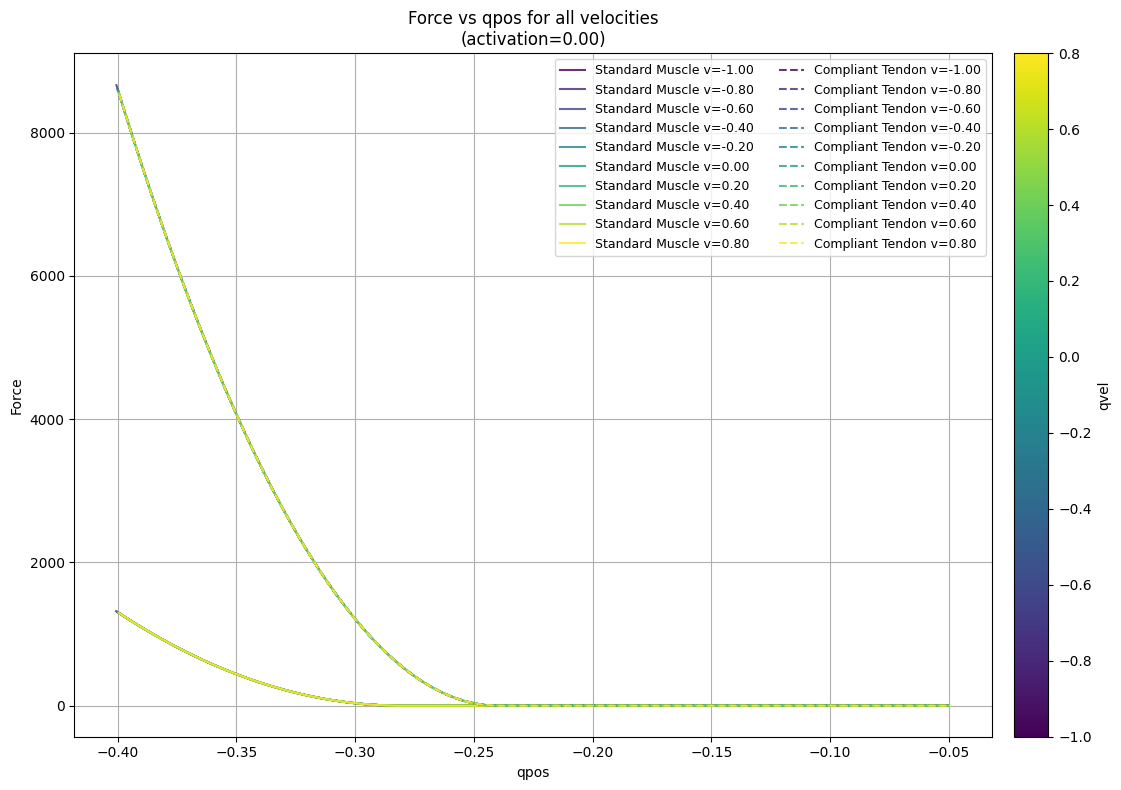

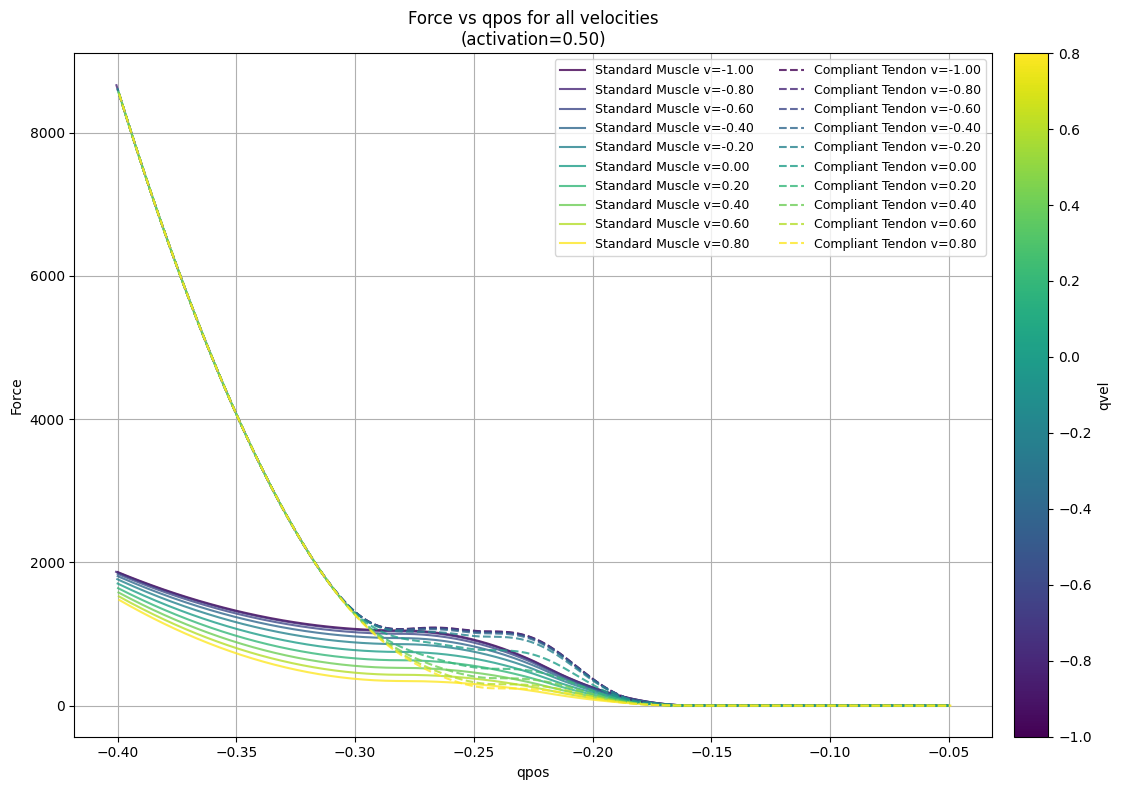

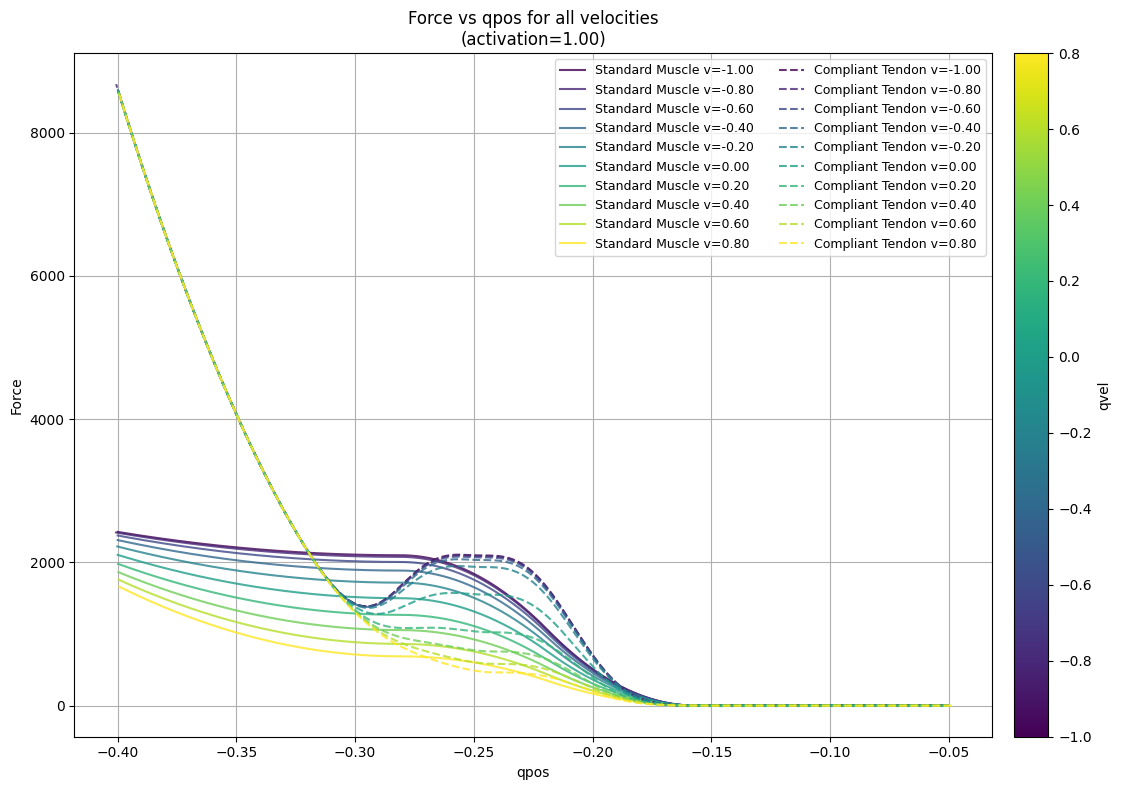

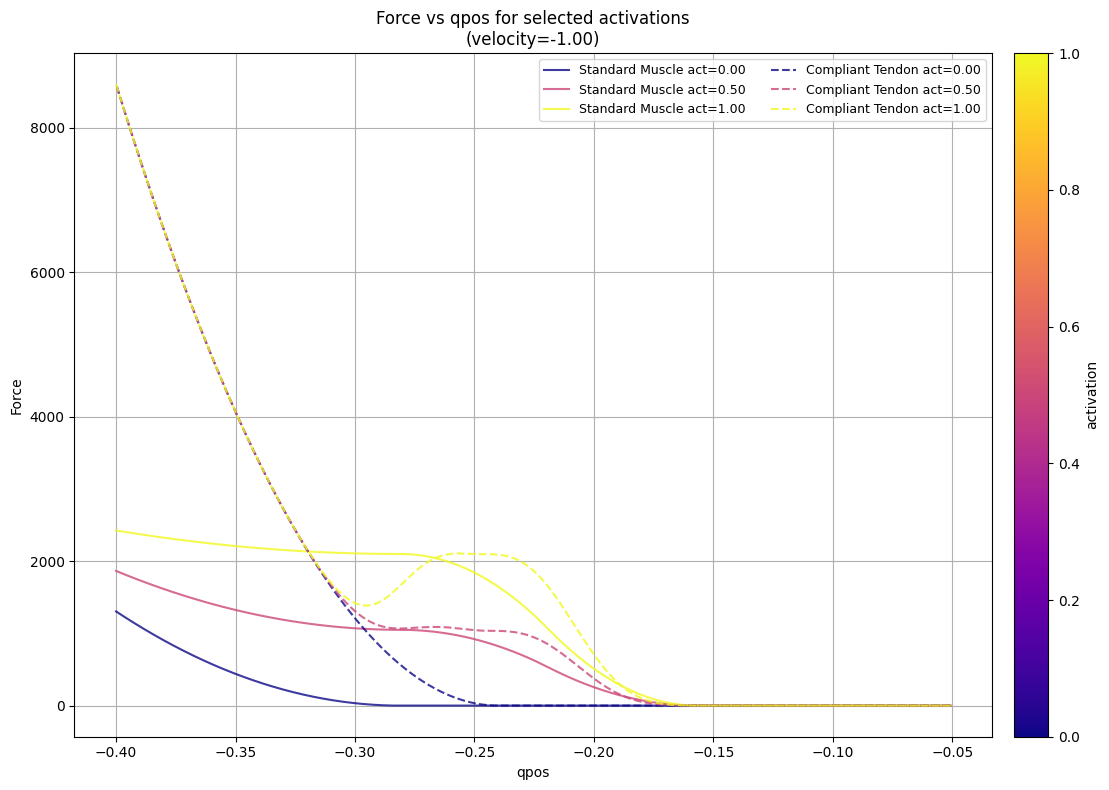

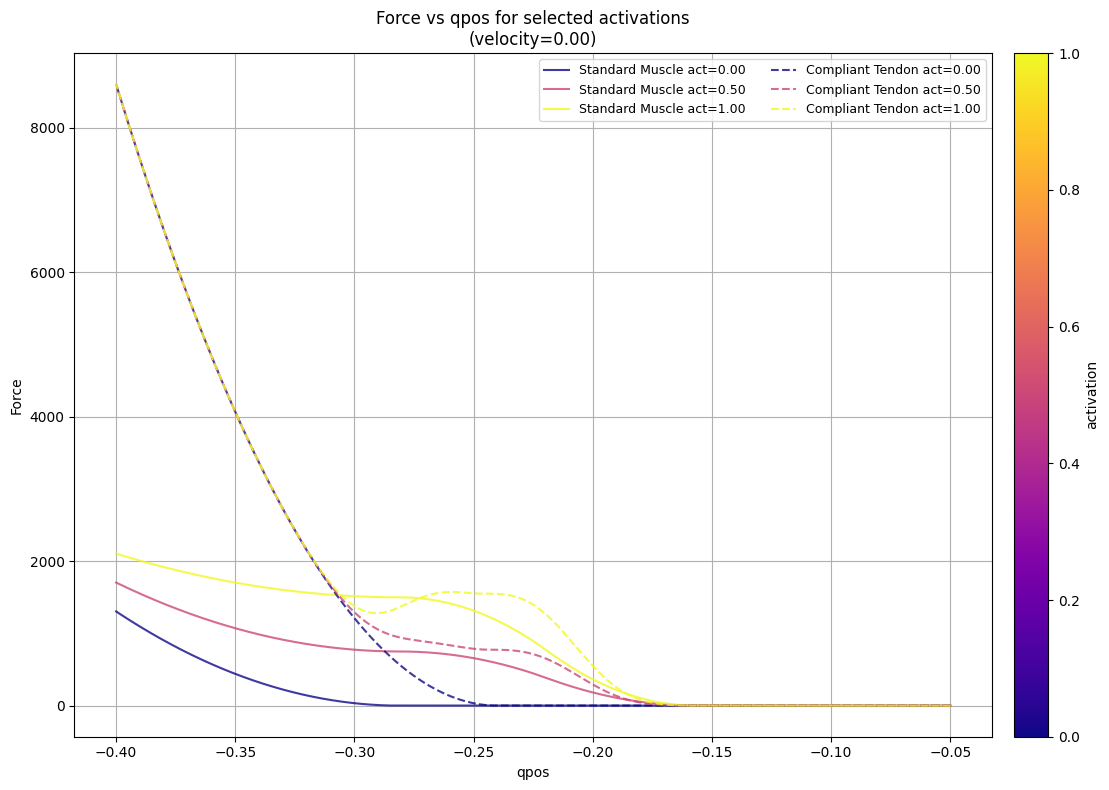

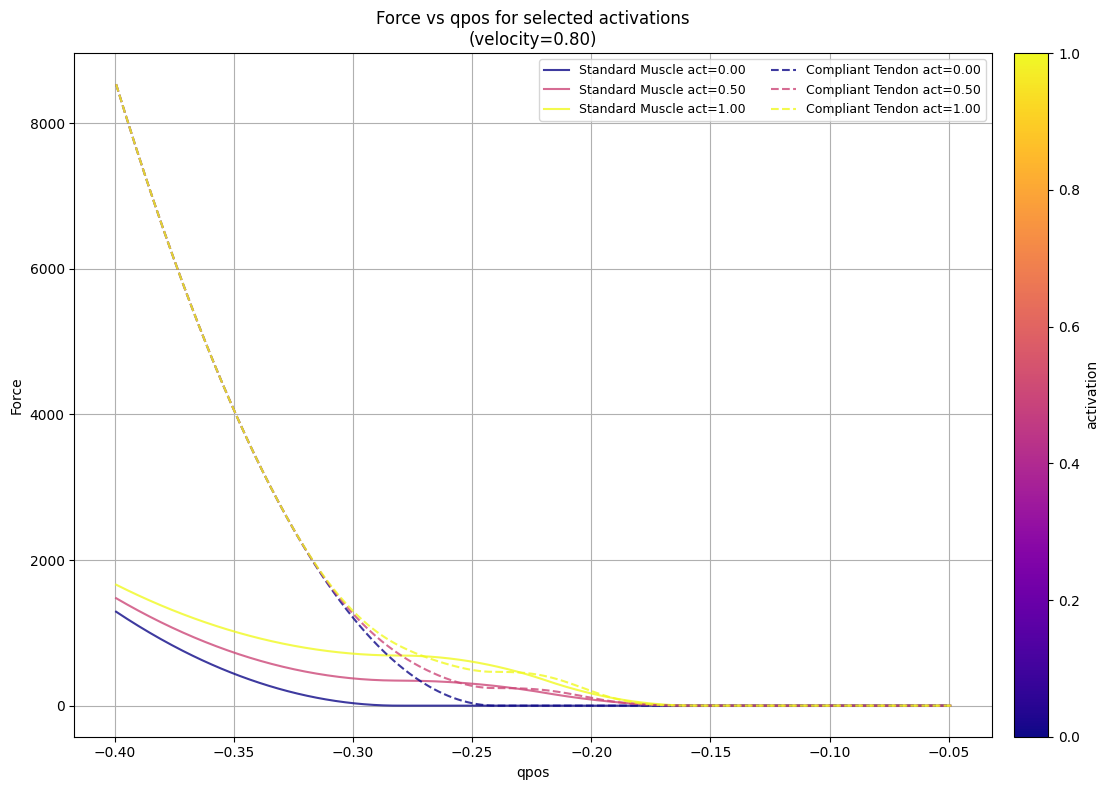

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# datas_by_vel_and_act: dict where key = velocity (float), value = dict (activation_value -> datas dict).
velocities = sorted(datas_by_vel_and_act.keys())
num_vel_episode = len(velocities)
# Extract activation_values from the first velocity (assume all velocities share the same activation values)
activation_values = sorted(datas_by_vel_and_act[velocities[0]].keys())
num_activation_episode = len(activation_values)

# actuator_info indexed by "default" and "compliant" for consistent labeling and style.
actuator_info = {
    "default": {"label": "Standard Muscle", "color": "blue", "linestyle": "-"},
    "compliant": {"label": "Compliant Tendon", "color": "red", "linestyle": "--"}
}

def plot_velocity_episodes_for_activation(xkey, ykey, ylabel, activation, title, xlim=None):
    """
    For a given activation value, plot all velocity episodes for both actuators.
    X-axis is qpos, Y-axis is ykey.
    Each actuator is shown with its color/linestyle; each curve is colored by velocity.
    If xlim is set, qpos is restricted to this range.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    color_map = plt.get_cmap('viridis')
    norm = plt.Normalize(vmin=min(velocities), vmax=max(velocities))

    lines, labels = [], []
    for actuator in actuator_info:
        for v in velocities:
            datas = datas_by_vel_and_act[v][activation]
            x = np.array(datas[f"{xkey}_{actuator}"])
            y = np.array(datas[f"{ykey}_{actuator}"])
            if xlim is not None:
                mask = (x >= xlim[0]) & (x <= xlim[1])
                x = x[mask]
                y = y[mask]
            line_color = color_map(norm(v))
            line, = ax.plot(
                x, y,
                color=line_color,
                linestyle=actuator_info[actuator]['linestyle'],
                alpha=0.8,
                label=f"{actuator_info[actuator]['label']} v={v:.2f}"
            )
            lines.append(line)
            labels.append(f"{actuator_info[actuator]['label']} v={v:.2f}")

    ax.set_xlabel("qpos")
    ax.set_ylabel(ylabel)
    ax.set_title(f"{title}\n(activation={activation:.2f})")
    ax.legend(lines, labels, fontsize=9, loc='best', ncol=2)
    sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label("qvel")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

def plot_activation_episodes_for_velocity(xkey, ykey, ylabel, velocity, title, act_idxs=None, xlim=None):
    """
    For a given velocity, plot selected activation episodes (default: first, middle, last) for both actuators.
    X-axis is qpos, Y-axis is ykey.
    Each actuator is shown with its color/linestyle; each curve is colored by activation value.
    """
    if act_idxs is None:
        act_idxs = [0, len(activation_values)//2, -1]  # indices for start, middle, end activation values
    acts_to_plot = [activation_values[i] for i in act_idxs]

    fig, ax = plt.subplots(figsize=(12, 8))
    color_map = plt.get_cmap('plasma')
    norm = plt.Normalize(vmin=min(acts_to_plot), vmax=max(acts_to_plot))
    lines, labels = [], []
    for actuator in actuator_info:
        for act in acts_to_plot:
            datas = datas_by_vel_and_act[velocity][act]
            x = np.array(datas[f"{xkey}_{actuator}"])
            y = np.array(datas[f"{ykey}_{actuator}"])
            if xlim is not None:
                mask = (x >= xlim[0]) & (x <= xlim[1])
                x = x[mask]
                y = y[mask]
            color = color_map(norm(act))
            line, = ax.plot(
                x, y,
                color=color,
                linestyle=actuator_info[actuator]['linestyle'],
                alpha=0.8,
                label=f"{actuator_info[actuator]['label']} act={act:.2f}"
            )
            lines.append(line)
            labels.append(f"{actuator_info[actuator]['label']} act={act:.2f}")

    ax.set_xlabel("qpos")
    ax.set_ylabel(ylabel)
    ax.set_title(f"{title}\n(velocity={velocity:.2f})")
    ax.legend(lines, labels, fontsize=9, loc='best', ncol=2)
    sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label("activation")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# Plot all velocities for selected activations (first, middle, last).
activation_indices = [0, len(activation_values)//2, num_activation_episode-1]
for idx in activation_indices:
    act_val = activation_values[idx]
    plot_velocity_episodes_for_activation(
        "qpos", "frc", ylabel="Force",
        activation=act_val,
        title=f"Force vs qpos for all velocities"
    )

# For each selected velocity (first, middle, last), plot all selected activations (all activations in one plot per velocity).
velocity_indices = [0, len(velocities)//2, num_vel_episode-1]
for v_idx in velocity_indices:
    vel = velocities[v_idx]
    plot_activation_episodes_for_velocity(
        "qpos", "frc", ylabel="Force",
        velocity=vel,
        title="Force vs qpos for selected activations",
        act_idxs=activation_indices
    )

# (You can adapt xkey/ykey/xlim/title as desired for other types of plots, e.g. activation vs qpos, etc.)


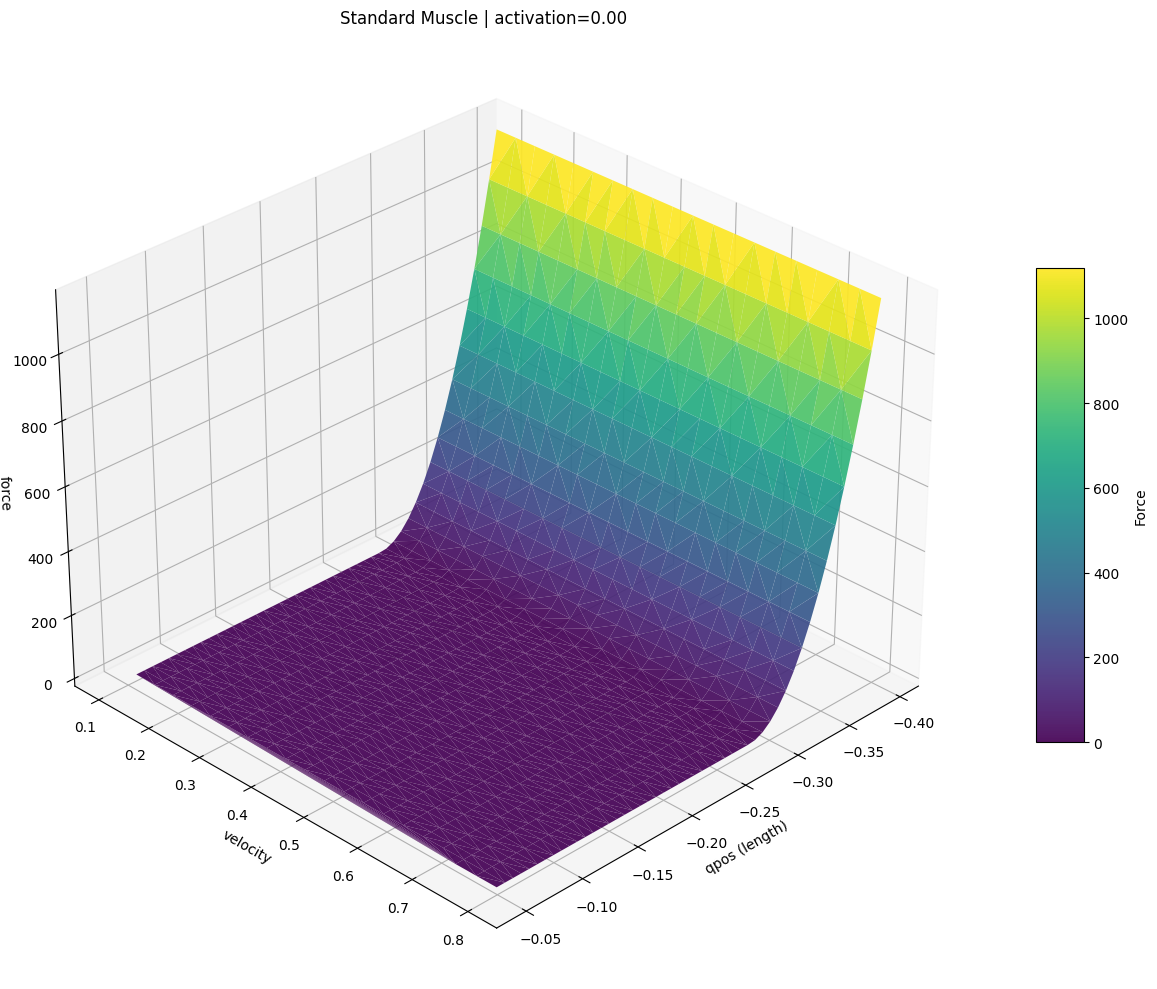

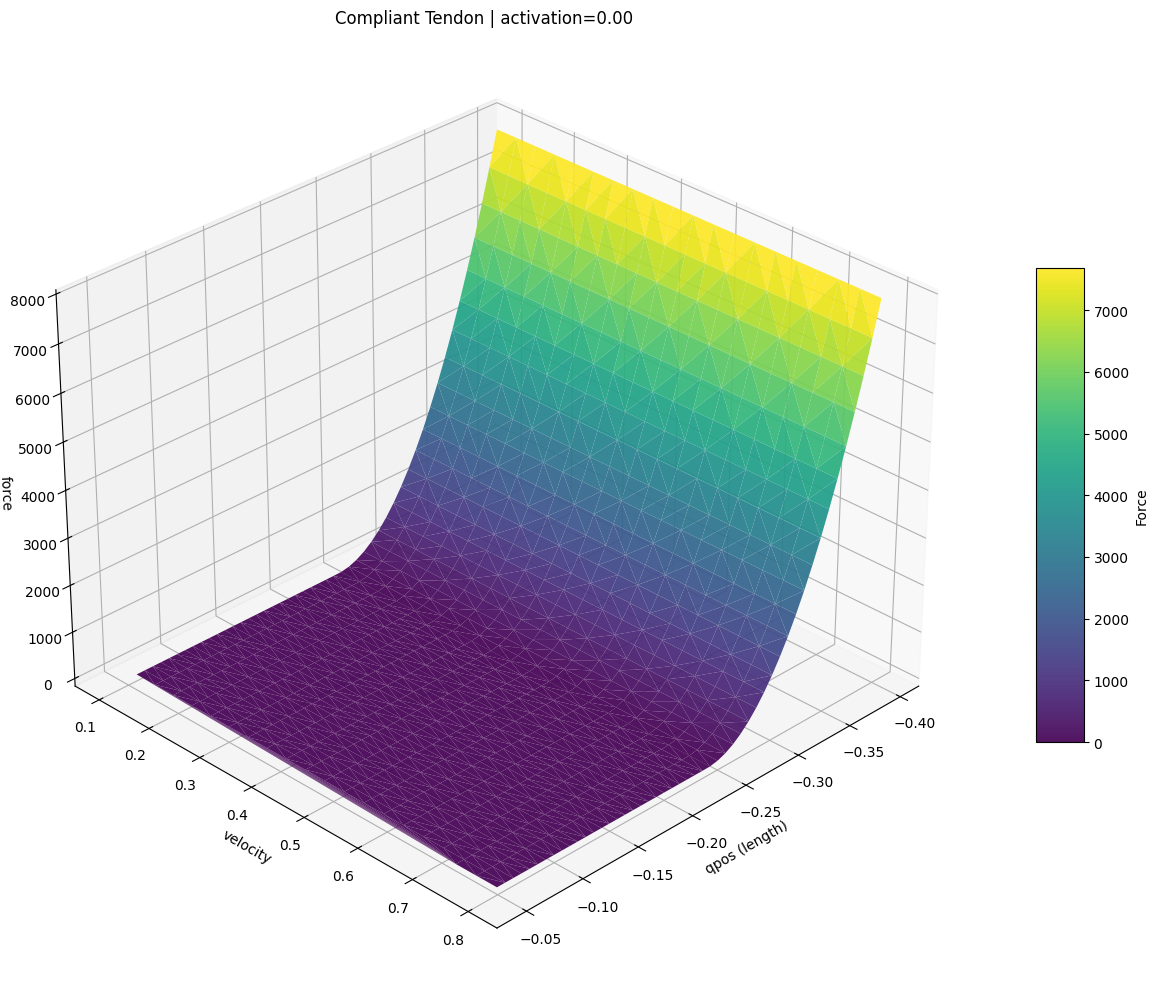

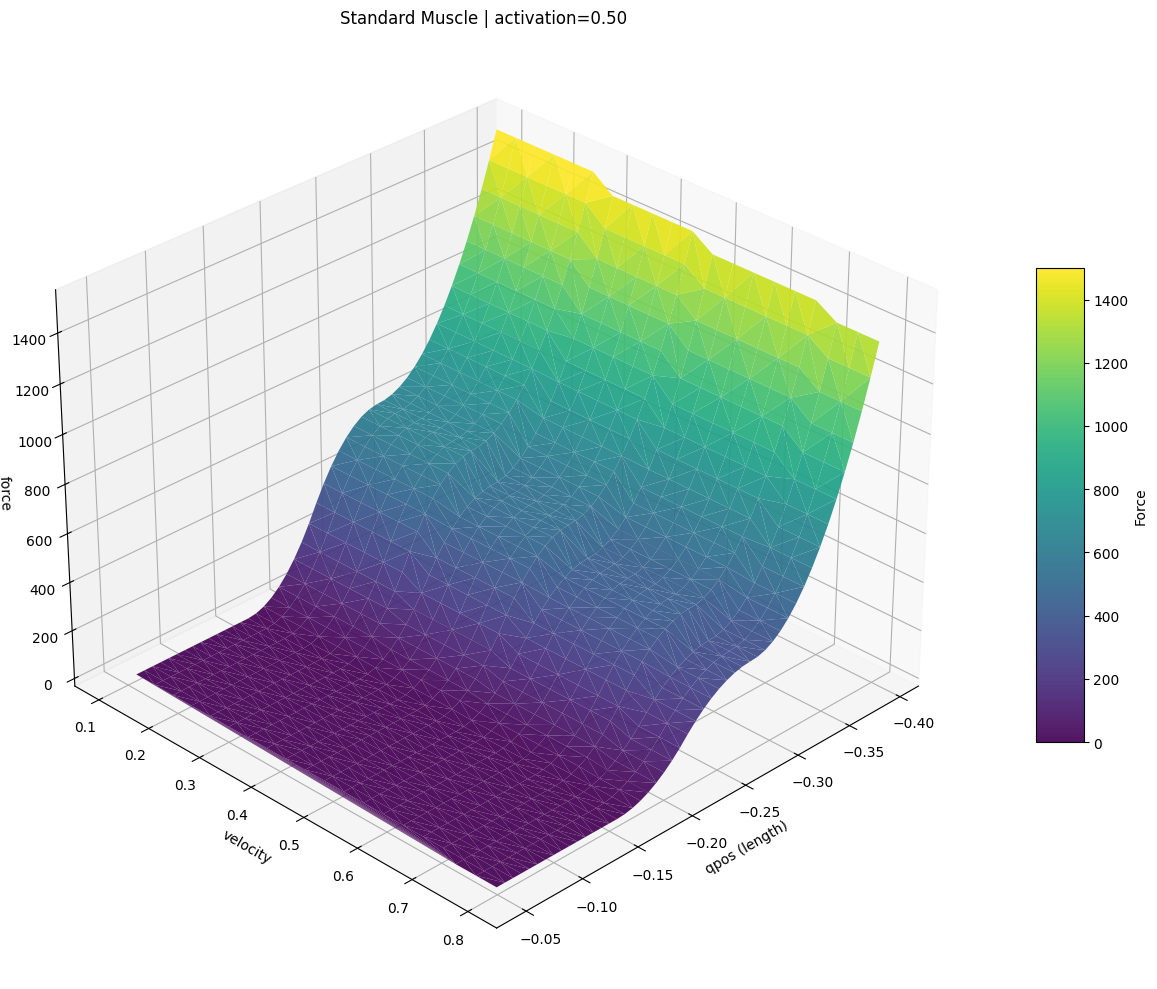

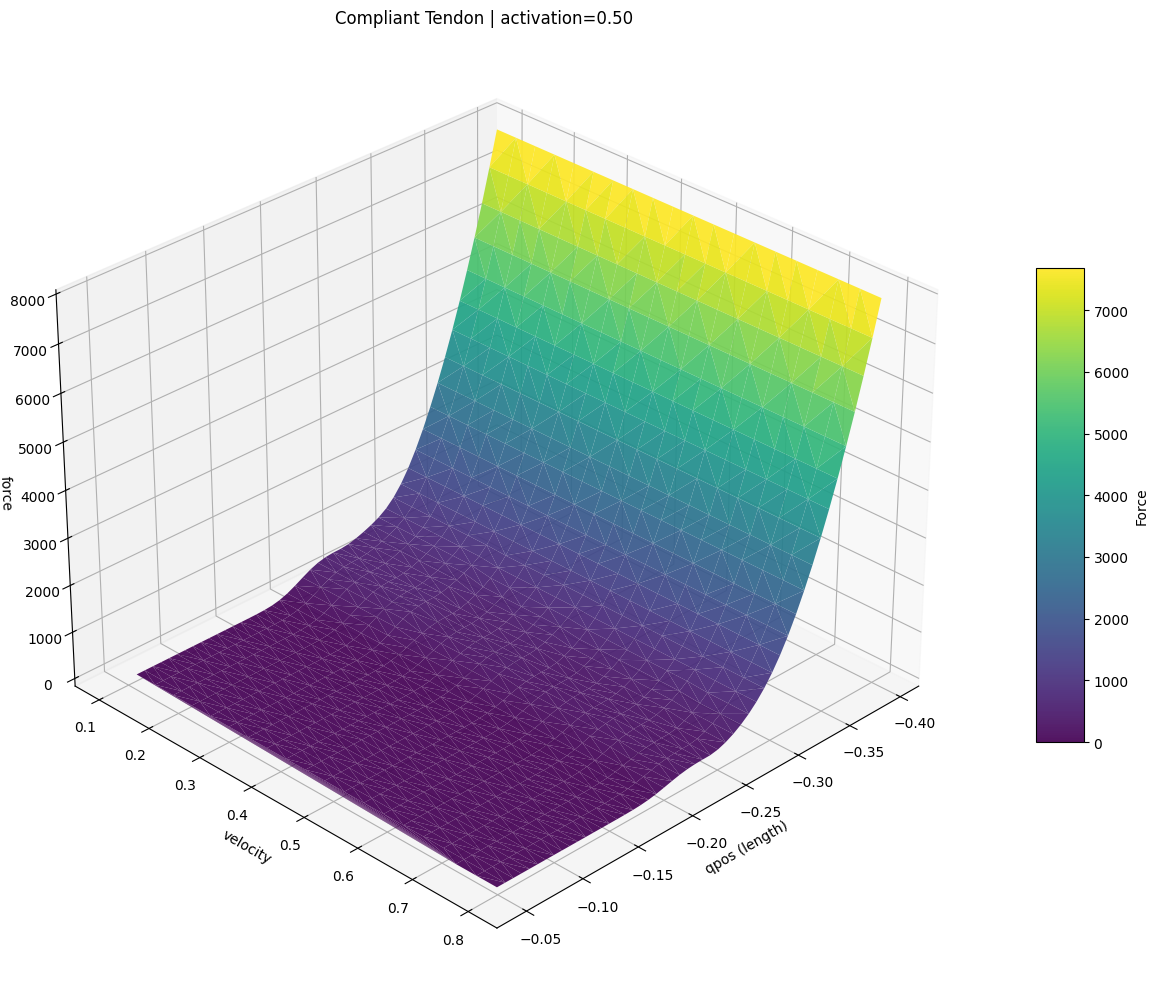

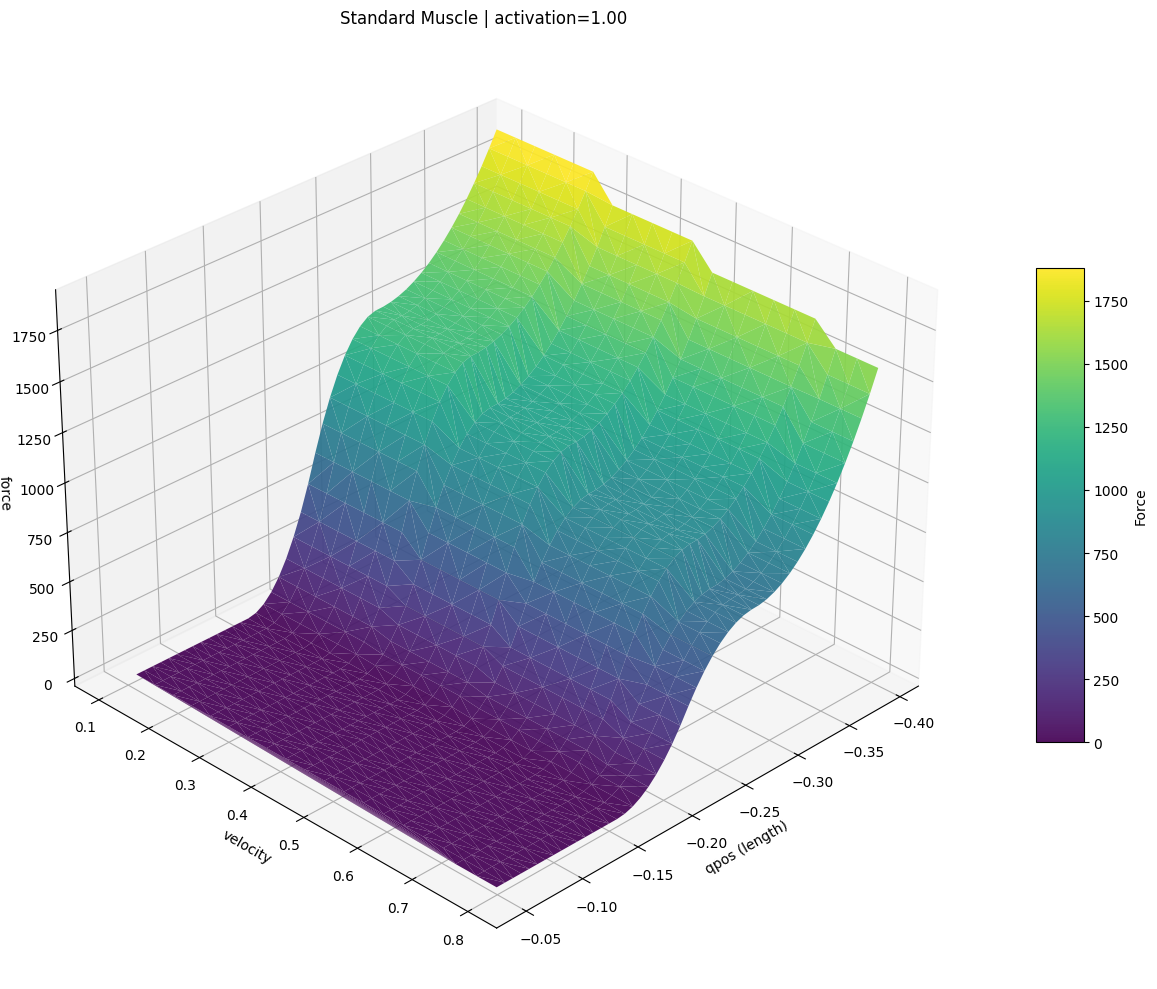

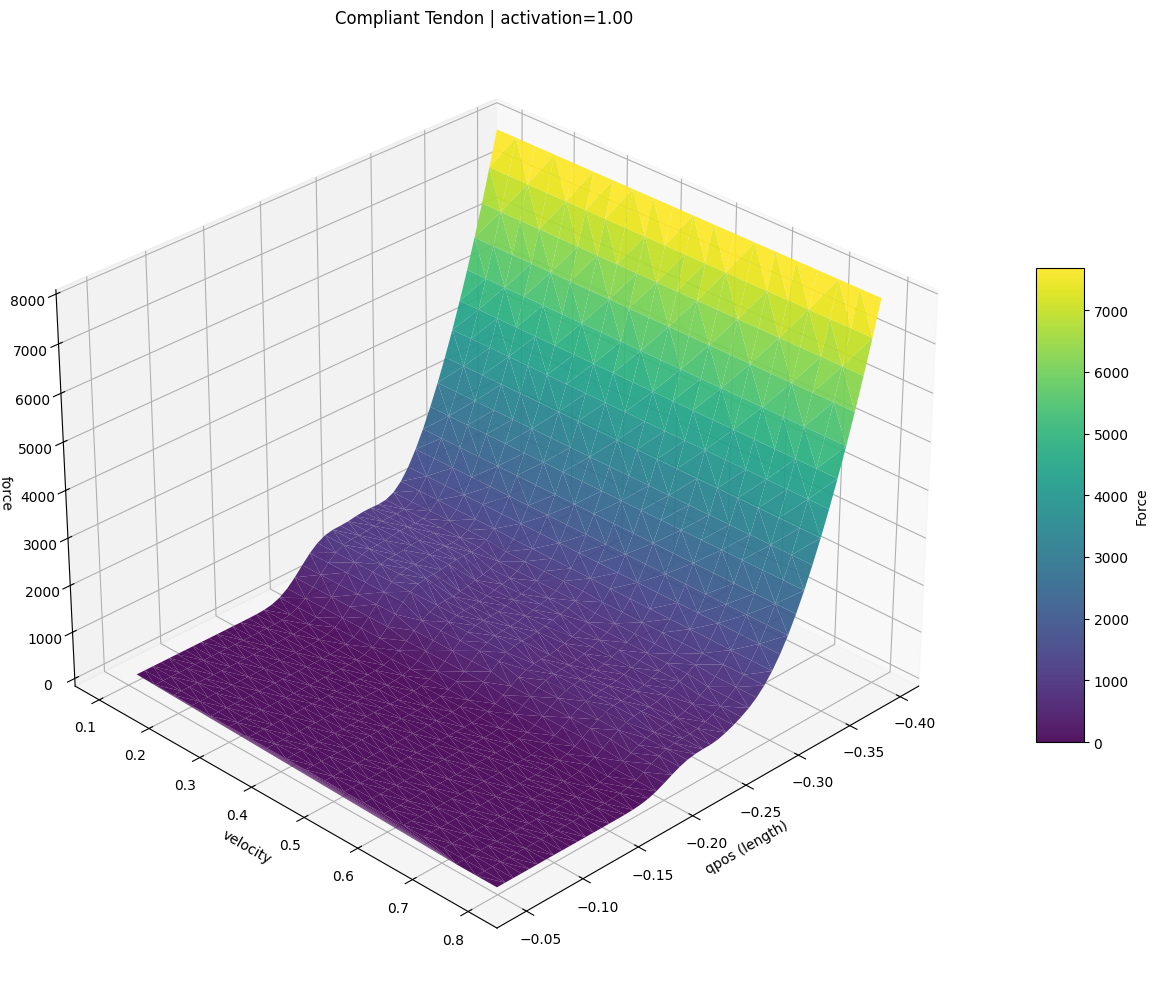

In [16]:
# 3D surface plot (using numpy only) for three activation values: min, max, and mid.
# For each selected activation, plot qpos (x), velocity (y), force (z) as a surface, for both actuators.

def plot_force_surface_for_activation_np_interpolated(activation, actuator="default", grid_n_qpos=50, grid_n_vel=50):
    """
    For a given activation, plot 3D surface: qpos (length) vs velocity vs force for the given actuator type.
    Interpolates with numpy only onto a regular grid for a smooth surface plot.
    The viewing angle is rotated.
    """
    # Find the global qpos min/max for this actuator, for all velocities for this activation
    qpos_min = float("+inf")
    qpos_max = float("-inf")
    for v in velocities:
        datas = datas_by_vel_and_act[v][activation]
        qpos = np.array(datas[f"qpos_{actuator}"])
        if len(qpos) > 1:
            qpos_min = min(qpos_min, qpos.min())
            qpos_max = max(qpos_max, qpos.max())
    if not (np.isfinite(qpos_min) and np.isfinite(qpos_max)):
        print("Invalid/empty qpos range.")
        return
    
    # Prepare a grid for velocity and qpos
    qpos_grid = np.linspace(qpos_min, qpos_max, grid_n_qpos)
    vel_grid = np.linspace(min(velocities), max(velocities), grid_n_vel)
    QPOS, VEL = np.meshgrid(qpos_grid, vel_grid)
    FORCE = np.zeros_like(QPOS)
    FORCE.fill(np.nan)

    # Interpolate: for each v (in vel_grid), use the closest episode, interpolate frc vs qpos
    for i, v in enumerate(vel_grid):
        idx_v = np.argmin(np.abs(np.array(velocities) - v))
        v_used = velocities[idx_v]
        datas = datas_by_vel_and_act[v_used][activation]
        qpos_true = np.array(datas[f"qpos_{actuator}"])
        frc_true  = np.array(datas[f"frc_{actuator}"])
        if len(qpos_true) < 2:
            continue
        # Interpolate force for points in the grid (np.interp is 1D, safe for qpos -> frc)
        f_interp = np.interp(
            qpos_grid,
            qpos_true,
            frc_true,
            left=np.nan, right=np.nan
        )
        FORCE[i, :] = f_interp

    # Plotting starts here
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111, projection='3d')

    from matplotlib import cm
    mask = ~np.isnan(FORCE)
    qpos_plot = QPOS[mask]
    vel_plot = VEL[mask]
    frc_plot = FORCE[mask]

    # Plot as trisurf (handles missing data correctly)
    surf = ax.plot_trisurf(qpos_plot, vel_plot, frc_plot, cmap=cm.viridis, linewidth=0, antialiased=True, alpha=0.92)

    ax.set_xlabel('qpos (length)')
    ax.set_ylabel('velocity')
    ax.set_zlabel('force')
    ax.set_title(f"{actuator_info[actuator]['label']} | activation={activation:.2f}")

    # Set the viewing angle so that velocity is on y, qpos on x, force on z. 90 deg azimuth swap.
    ax.view_init(elev=30, azim=45)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Force')
    plt.tight_layout()
    plt.show()


# Plot for three activations: min, max, and mid, for both actuators.
activation_list = [activation_values[0], activation_values[len(activation_values)//2], activation_values[-1]]
for activation in activation_list:
    for actuator in actuator_info:
        plot_force_surface_for_activation_np_interpolated(activation, actuator=actuator)





